##Importing Libraries

In [ ]:
from pandas import read_csv
import pandas as pd
import io
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import datetools
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
filterwarnings('ignore')
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from sklearn.metrics import mean_absolute_error
import io
from numpy import array
import itertools
from pandas.plotting import autocorrelation_plot
from operator import itemgetter
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

##Reading Data.


We have data in 3 files:
1. Training Features
2. Training labels
3. Test Labels

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dengue_features_test.csv to dengue_features_test.csv
Saving dengue_features_train.csv to dengue_features_train.csv
Saving dengue_labels_train.csv to dengue_labels_train.csv


In [ ]:
trainingFeatures = read_csv('dengue_features_train.csv', header=0)
trainingLabels = read_csv('dengue_labels_train.csv', header=0)
testingData = read_csv('dengue_features_test.csv', header=0)

Traning data contains following features:

City and date indicators

1.    city – City abbreviations: sj for San Juan and iq for Iquitos
2.    week_start_date – Date given in yyyy-mm-dd format

NOAA's GHCN daily climate data weather station measurements

3.    station_max_temp_c – Maximum temperature
4.    station_min_temp_c – Minimum temperature
5.    station_avg_temp_c – Average temperature
6.    station_precip_mm – Total precipitation
7.    station_diur_temp_rng_c – Diurnal temperature range

PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)

8.    precipitation_amt_mm – Total precipitation

NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)

9.    reanalysis_sat_precip_amt_mm – Total precipitation
10.    reanalysis_dew_point_temp_k – Mean dew point temperature
11.    reanalysis_air_temp_k – Mean air temperature
12.    reanalysis_relative_humidity_percent – Mean relative humidity
13.    reanalysis_specific_humidity_g_per_kg – Mean specific humidity
14.    reanalysis_precip_amt_kg_per_m2 – Total precipitation
15.    reanalysis_max_air_temp_k – Maximum air temperature
16.    reanalysis_min_air_temp_k – Minimum air temperature
17.    reanalysis_avg_temp_k – Average air temperature
18.    reanalysis_tdtr_k – Diurnal temperature range

Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements

19.    ndvi_se – Pixel southeast of city centroid
20.    ndvi_sw – Pixel southwest of city centroid
21.    ndvi_ne – Pixel northeast of city centroid
22.    ndvi_nw – Pixel northwest of city centroid


##Data Preprocessing:

In [ ]:
trainingFeatures.sample(10)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
178,sj,1993,39,1993-10-01,0.034000,0.051700,0.072600,0.094233,72.86,299.885714,299.942857,296.651429,302.1,298.4,76.00,82.610000,72.86,18.120000,2.171429,28.285714,6.985714,32.8,23.9,26.7
499,sj,1999,48,1999-12-03,0.153600,0.104775,0.113233,0.098986,2.11,298.782857,299.057143,294.775714,301.0,296.8,8.70,78.682857,2.11,16.207143,3.257143,26.100000,7.471429,30.6,21.1,13.2
1114,iq,2003,49,2003-12-03,0.400343,0.318057,0.328771,0.369643,72.23,298.315714,299.735714,296.135714,309.4,293.5,77.83,89.207143,72.23,17.745714,9.700000,28.766667,10.166667,35.1,22.0,138.0
575,sj,2001,21,2001-05-21,0.086080,0.077360,0.170143,0.167943,35.54,299.951429,299.985714,295.345714,302.2,297.6,2.00,76.070000,35.54,16.730000,3.828571,28.828571,8.328571,33.9,23.3,7.4
477,sj,1999,26,1999-07-02,NaN,0.063000,0.164571,0.130714,17.32,300.148571,300.257143,296.622857,302.4,298.3,25.74,81.250000,17.32,18.051429,2.342857,28.442857,5.328571,31.7,25.0,5.4
1343,iq,2008,18,2008-04-29,0.061729,0.133900,0.094714,0.117843,42.12,298.072857,299.414286,296.741429,306.3,293.1,115.99,93.662857,42.12,18.398571,8.685714,27.866667,8.000000,32.5,22.7,31.2
876,sj,2007,10,2007-03-05,0.054300,-0.018900,0.183700,0.120857,0.00,299.114286,299.250000,294.328571,301.5,296.9,3.70,75.014286,0.00,15.697143,3.071429,26.557143,7.671429,32.2,22.2,8.4
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
372,sj,1997,26,1997-06-25,0.074900,0.077620,0.130214,0.136800,34.69,300.044286,300.092857,296.322857,302.0,298.4,23.40,80.245714,34.69,17.732857,2.185714,28.657143,6.685714,32.8,23.9,18.6
577,sj,2001,23,2001-06-04,0.031200,0.025350,0.170629,0.190100,61.33,299.944286,299.850000,295.568571,302.2,297.6,5.85,77.162857,61.33,16.922857,3.642857,28.071429,7.228571,32.8,23.9,6.7


We have weakly data for Dengue cases in two cities

In [ ]:
trainingLabels.sample(10)

,city,year,weekofyear,total_cases
713,sj,2004,3,14
633,sj,2002,27,2
364,sj,1997,18,8
1384,iq,2009,7,20
587,sj,2001,33,38
1,sj,1990,19,5
310,sj,1996,16,11
1226,iq,2006,4,28
343,sj,1996,49,22
70,sj,1991,36,64


Merging Training features and labels

In [ ]:
trainingData = pd.merge(trainingLabels, trainingFeatures, on=['city','year','weekofyear'])
trainingData.sample(10)

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1315,iq,2007,42,6,2007-10-15,0.225129,0.150514,0.195986,0.238386,74.52,299.444286,300.828571,296.587143,310.2,295.0,86.40,86.705714,74.52,18.265714,9.828571,29.000000,12.300000,35.2,21.9,4.1
536,sj,2000,33,9,2000-08-19,0.176450,0.130400,0.252200,0.205457,8.62,300.528571,300.557143,296.635714,302.8,298.6,27.72,79.507143,8.62,18.067143,2.200000,28.614286,6.442857,32.8,23.9,26.9
489,sj,1999,38,60,1999-09-24,0.083050,0.065350,0.136029,0.104629,44.44,300.572857,300.621429,296.701429,302.8,298.3,30.40,79.390000,44.44,18.214286,2.700000,28.457143,6.600000,32.2,24.4,31.3
416,sj,1998,18,36,1998-04-30,0.106300,0.046100,0.219186,0.207329,71.64,299.565714,299.835714,295.834286,301.5,298.2,11.70,80.072857,71.64,17.231429,2.357143,26.871429,6.900000,31.1,22.8,16.3
1313,iq,2007,40,6,2007-10-01,0.319971,0.254417,0.315100,0.293471,37.28,298.281429,299.821429,296.287143,310.8,294.7,73.33,89.844286,37.28,17.840000,9.100000,28.400000,12.650000,35.5,21.6,107.9
106,sj,1992,20,26,1992-05-13,0.101875,-0.008800,0.142067,0.125900,2.94,298.334286,298.514286,294.275714,300.4,296.4,27.50,78.381429,2.94,15.687143,2.228571,27.442857,5.957143,31.1,22.8,8.1
1292,iq,2007,19,4,2007-05-07,0.158257,0.162286,0.183071,0.232271,89.15,296.905714,298.221429,295.994286,306.6,291.7,56.10,95.037143,89.15,17.611429,9.357143,28.100000,9.200000,33.5,21.5,38.1
325,sj,1996,31,9,1996-07-29,0.096833,0.115000,0.198614,0.204443,41.78,299.394286,299.457143,296.030000,301.4,297.5,39.10,81.910000,41.78,17.390000,2.200000,27.171429,5.157143,30.0,23.9,79.3
144,sj,1993,5,35,1993-02-05,0.047425,0.022533,0.092386,0.094686,75.97,297.624286,297.685714,294.032857,300.4,295.6,26.30,80.610000,75.97,15.452857,2.085714,26.671429,7.642857,31.7,19.4,9.4
44,sj,1991,10,21,1991-03-05,0.210750,0.264100,0.247686,0.216357,0.00,297.777143,298.078571,293.531429,300.3,296.4,8.30,77.315714,0.00,14.920000,2.242857,26.014286,8.314286,31.1,20.6,10.9


We will split traning data city vise

In [ ]:
filterwarnings('ignore')
cases_all =  trainingData[['week_start_date', 'total_cases', 'city']]
cases_sj =  cases_all[cases_all.city == 'sj']
cases_sj.drop('city', axis = 1, inplace = True)
cases_sj.set_index('week_start_date', inplace = True)
cases_iq =  cases_all[cases_all.city == 'iq']
cases_iq.drop('city', axis = 1, inplace = True)
cases_iq.set_index('week_start_date', inplace = True)

In [ ]:
cases_sj = cases_sj.sort_index()
cases_sj

,total_cases
week_start_date,
1990-04-30,4
1990-05-07,5
1990-05-14,4
1990-05-21,3
1990-05-28,6
...,...
2008-03-25,4
2008-04-01,3
2008-04-08,1


In [ ]:
cases_iq = cases_iq.sort_index()
cases_iq

,total_cases
week_start_date,
2000-07-01,0
2000-07-08,0
2000-07-15,0
2000-07-22,0
2000-07-29,0
...,...
2010-05-28,5
2010-06-04,8
2010-06-11,1


Before taking into consideration all the features, we will explore the Dengue cases observations alone as a time series.

We will apply seprate models to both the cities data.


Comparing the cases of two cities:

##Visualizing time series for both cities:

Text(0.5, 1.0, 'sj cases')

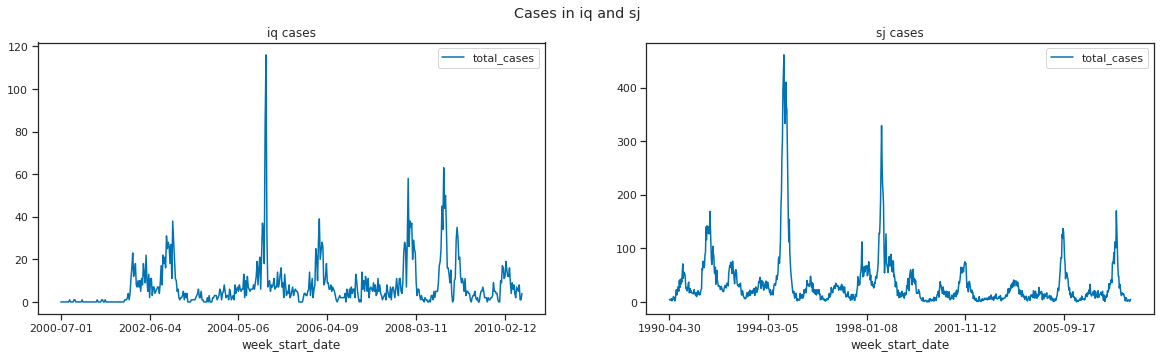

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Cases in iq and sj')
fig.set_size_inches(20,5)
ax = cases_iq.plot(ax=ax1);
ax1.set_title('iq cases')
ax = cases_sj.plot(ax=ax2);
ax2.set_title('sj cases')

##Visualizing Weekly Mean of all data:

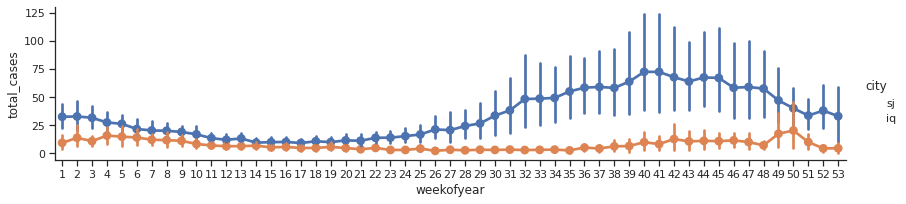

In [ ]:
sns.set(style="ticks")
fig = sns.FacetGrid(trainingData, hue='city', aspect=4)
fig.map(sns.pointplot,'weekofyear','total_cases')
fig.add_legend()

## ADFuller Test

ADFuller Test for iq:

In [ ]:
result = adfuller(cases_iq.iloc[:,0].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.085429
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


ADFuller test for sj:

In [ ]:
result = adfuller(cases_sj.iloc[:,0].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.650078
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


An Augmented Dickey-Fuller Test suggests that the time series dataset is stationary. The dataset has complex seasonality with weekly data points (frequency = 52.18).

##Decomposing Time Series:

Decomposition of iq:

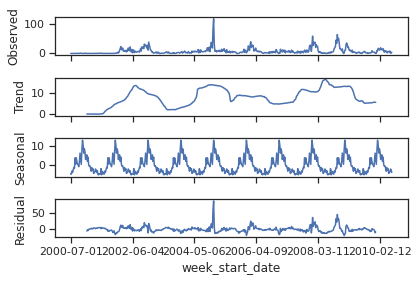

In [ ]:
result1 = seasonal_decompose(cases_iq, model='additive', freq=53)
result1.plot();

Decomposition of sj

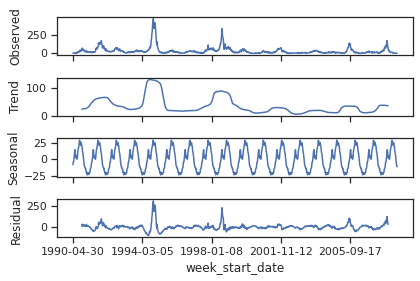

In [ ]:
result1 = seasonal_decompose(cases_sj, model='additive', freq=53)
result1.plot();

## Visualizing ACF and PACF

ACF and PACF of iq

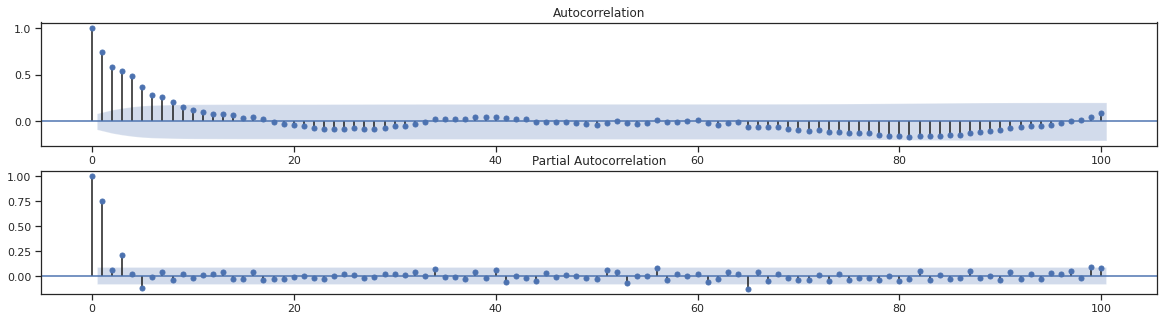

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
fig = plot_acf(cases_iq, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(cases_iq, lags=100, ax=ax2)

ACF and PACF of sj

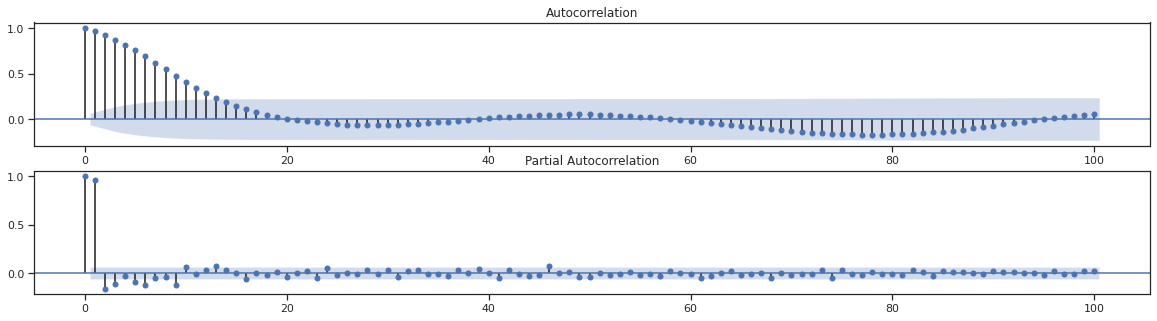

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
fig = plot_acf(cases_sj, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(cases_sj, lags=100, ax=ax2)

To pick MA and AR terms, we first examined the early lags (1, 2, 3, …) to judge non-seasonal terms. Those spikes in the ACF at low lags indicate non-seasonal MA terms. Additionally, the spike in the PACF at low lags indicates a possible non-seasonal AR term.



---


# Implementing ETS

In [ ]:
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

def measure_mae(actual, predicted):
	return mean_absolute_error(actual, predicted)

def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_mae(test, predictions)
	return error

def score_model(data, n_test,cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)


def grid_search(data, cfg_list, n_test,model, parallel=True):
	scores = None
	rslt =None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores


def exp_smoothing_configs(seasonal=[None]):
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = seasonal
	b_params = [True, False,'log']
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models





##ETS Grid Search for iquitos

In [ ]:
	data = cases_iq.values
	# data split
	n_test = 54
	# model configs
	cfg_list = exp_smoothing_configs(seasonal = [53])
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[['add', False, 'add', 9, False, True]] 2.498
 > Model[['add', False, 'add', 9, False, False]] 2.498
 > Model[['add', False, 'add', 53, False, True]] 2.945
 > Model[['add', False, None, None, False, True]] 2.518
 > Model[['add', False, None, None, False, False]] 2.518
 > Model[['add', False, None, 9, False, True]] 2.518
 > Model[['add', False, None, 9, False, False]] 2.518
 > Model[['add', False, 'add', 53, False, False]] 2.945
 > Model[['add', False, None, 53, False, True]] 2.518
 > Model[['add', False, None, 53, False, False]] 2.518
 > Model[[None, False, None, 9, False, True]] 2.518
 > Model[[None, False, 'add', 9, False, True]] 2.498
 > Model[[None, False, None, 9, False, False]] 2.513
 > Model[[None, False, None, 53, False, True]] 2.518
 > Model[[None, False, None, 53, False, False]] 2.513
 > Model[[None, False, 'add', 9, False, False]] 2.493
 > Model[[None, False, 'add', 53, False, True]] 2.925
 > Model[[None, False, 'add', 53, False, False]] 2.922
 > Model[[None, False, 

Best model for iquitos : [None, False, 'add', 53, False, False] 2.4932672373078852


---
## ETS Grid Search for sj


In [ ]:
	data = cases_sj.values
	# data split
	n_test = 108
	# model configs
	cfg_list = exp_smoothing_configs(seasonal = [53])
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[['add', True, 'add', 9, False, True]] 7.873
 > Model[['add', True, 'add', 53, False, True]] 8.022
 > Model[['add', True, 'add', 9, False, False]] 7.866
 > Model[['add', True, 'add', 53, False, False]] 8.017
 > Model[['add', True, None, None, False, True]] 7.439
 > Model[['add', True, None, 9, False, True]] 7.439
 > Model[['add', True, None, None, False, False]] 7.432
 > Model[['add', True, None, 9, False, False]] 7.432
 > Model[['add', True, None, 53, False, True]] 7.439
 > Model[['add', True, None, 53, False, False]] 7.432
 > Model[['add', False, 'add', 9, False, True]] 7.369
 > Model[['add', False, 'add', 9, False, False]] 7.358
 > Model[['add', False, 'add', 53, False, True]] 8.020
 > Model[['add', False, None, None, False, True]] 7.118
 > Model[['add', False, None, None, False, False]] 7.118
 > Model[['add', False, 'add', 53, False, False]] 8.013
 > Model[['add', False, None, 9, False, True]] 7.118
 > Model[['add', False, None, 53, False, True]] 7.118
 > Model[['add', Fals

Best model for sj : [None, False, 'add', 53, False, False] 7.094331655975669

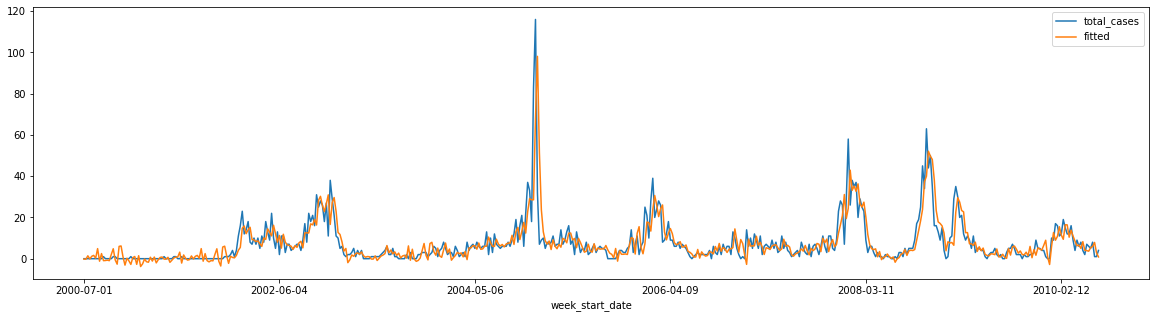

In [ ]:
mod = ExponentialSmoothing(cases_iq, trend=None, damped=False, seasonal='add', seasonal_periods=53)
results = mod.fit(optimized=True, use_boxcox=False, remove_bias=False)

pred = results.predict(start='2000-07-01')

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax = cases_iq.plot(ax=ax);
ax = pred.plot(ax=ax , label='fitted');
ax.legend()




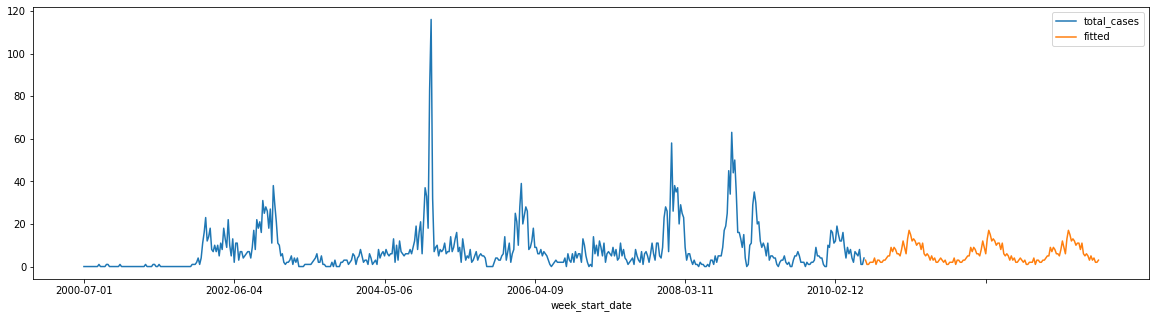

In [ ]:
pred_iq = results.forecast(156)
pred_iq = pred_iq.astype(int)
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax = cases_iq.plot(ax=ax);
ax = pred_iq.plot(ax=ax , label='fitted');
ax.legend()



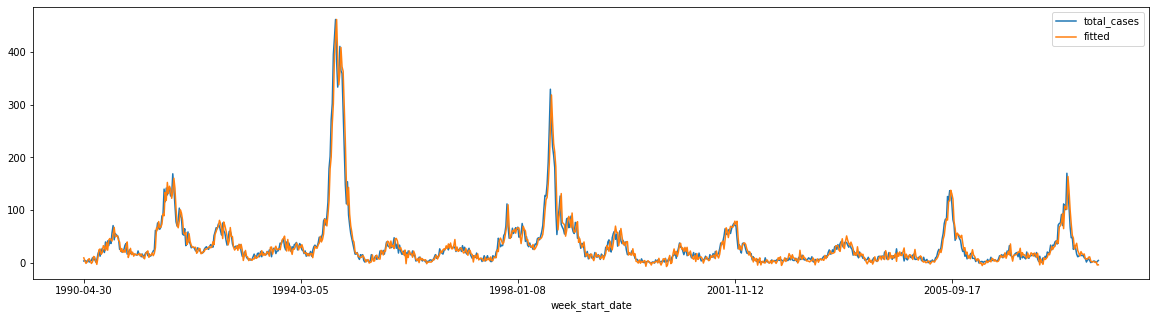

In [ ]:
mod = ExponentialSmoothing(cases_sj, trend=None, damped=False, seasonal='add', seasonal_periods=53)
results = mod.fit(optimized=True, use_boxcox=False, remove_bias=False)

pred = results.predict(start='1990-04-30')

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax = cases_sj.plot(ax=ax);
ax = pred.plot(ax=ax , label='fitted');
ax.legend()

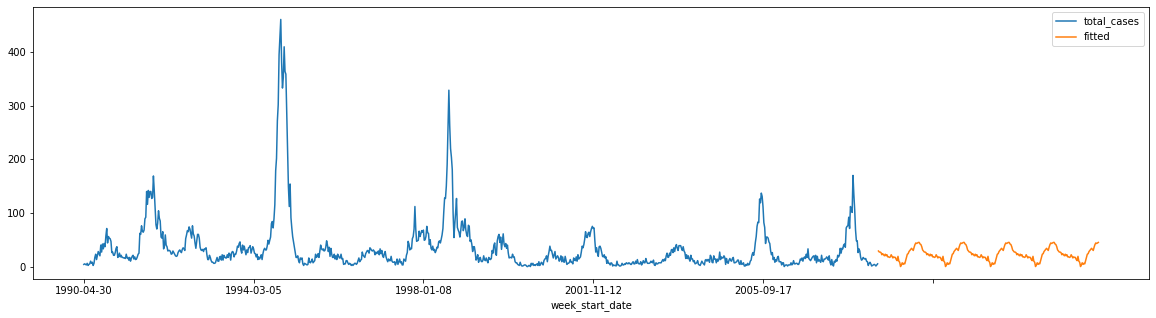

In [ ]:
pred = results.forecast(260)
pred_sj = pred + abs(pred.min())
pred_sj = pred_sj.astype(int)
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax = cases_sj.plot(ax=ax);
ax = pred_sj.plot(ax=ax , label='fitted');
ax.legend()

#df[list("ABCD")] = df[list("ABCD")].astype(int)


In [ ]:
from google.colab import drive
drive.mount('drive')
def create_submission(forecast_sj, forecast_iq, sub_name):

    test_index = testingData[['city', 'year', 'weekofyear']]

    output = pd.concat([forecast_sj, forecast_iq])\
        .reset_index().drop(['index'], axis=1)

    output.columns = ['total_cases']

    pd.concat([test_index, output], axis=1)\
        .set_index(['city']).to_csv(sub_name + '.csv')

    !cp DengAI_ETS.csv "drive/My Drive/"

create_submission(pred_sj, pred_iq, 'DengAI_ETS')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Test Score of ETS = 31.0288 Rank = 2942/9007



---


# Implementing SARIMA

Text(0.5, 1.0, 'iq cases resampled')

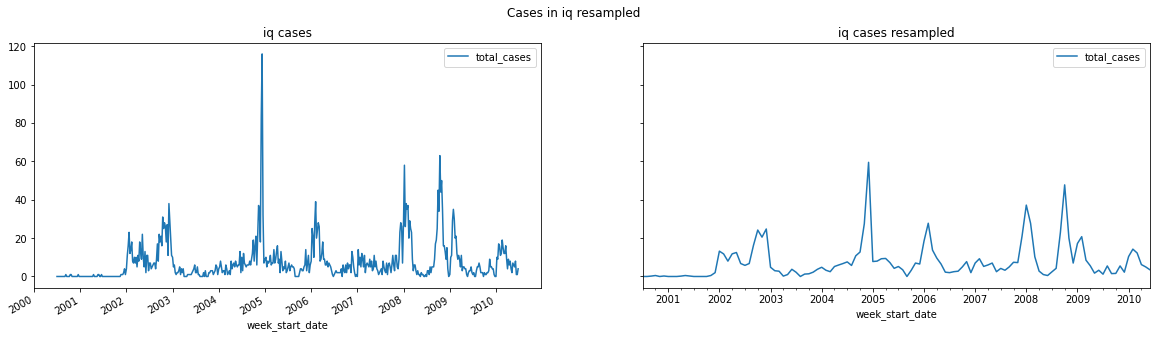

In [ ]:
resample_iq = cases_iq
resample_iq.index = pd.to_datetime(resample_iq.index)
resample_iq = cases_iq.resample('M').mean()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Cases in iq resampled')
fig.set_size_inches(20,5)
ax = cases_iq.plot(ax=ax1);
ax1.set_title('iq cases')
ax = resample_iq.plot(ax=ax2);
ax2.set_title('iq cases resampled')

Text(0.5, 1.0, 'sj cases resampled')

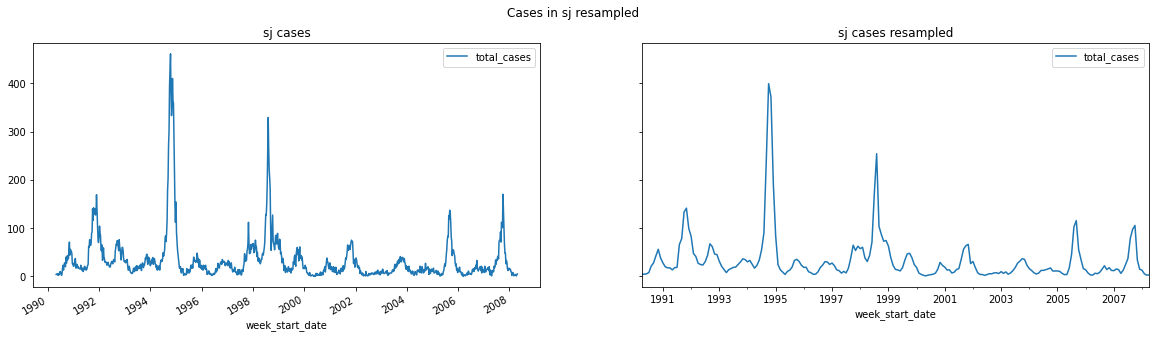

In [ ]:
resample_sj = cases_sj
resample_sj.index = pd.to_datetime(resample_sj.index)
resample_sj = cases_sj.resample('M').mean()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Cases in sj resampled')
fig.set_size_inches(20,5)
ax = cases_sj.plot(ax=ax1);
ax1.set_title('sj cases')
ax = resample_sj.plot(ax=ax2);
ax2.set_title('sj cases resampled')

## SARIMA Grid Search

In [ ]:

# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder= config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history), dynamic=True)
	return yhat[0]

# root mean squared error or rmse
def measure_mae(actual, predicted):
	return mean_absolute_error(actual, predicted)

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_mae(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[None]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	#t_params = ['n']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				#for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									if p+d+q+P+D+Q < 7:
									    cfg = [(p,d,q), (P,D,Q,m)]
									    models.append(cfg)
	return models


##SARIMA Grid Search for Iquitos

### Walk Forward

In [ ]:

	# define dataset
	data = resample_iq.values
	#print(data)
	# data split
	n_test = 12
	# model configs
	cfg_list = sarima_configs(seasonal = [12])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 12)]] 5.763
 > Model[[(0, 0, 0), (0, 0, 1, 12)]] 5.344
 > Model[[(0, 0, 0), (0, 1, 0, 12)]] 9.208
 > Model[[(0, 0, 0), (0, 1, 1, 12)]] 4.341
 > Model[[(0, 0, 0), (0, 0, 2, 12)]] 5.008
 > Model[[(0, 0, 0), (1, 0, 0, 12)]] 5.177
 > Model[[(0, 0, 0), (1, 0, 1, 12)]] 4.043
 > Model[[(0, 0, 0), (1, 0, 2, 12)]] 3.829
 > Model[[(0, 0, 0), (0, 1, 2, 12)]] 4.618
 > Model[[(0, 0, 0), (1, 1, 0, 12)]] 8.127
 > Model[[(0, 0, 0), (2, 0, 0, 12)]] 5.213
 > Model[[(0, 0, 0), (1, 1, 1, 12)]] 4.767
 > Model[[(0, 0, 0), (2, 0, 1, 12)]] 4.004
 > Model[[(0, 0, 0), (2, 0, 2, 12)]] 4.035
 > Model[[(0, 0, 0), (2, 1, 0, 12)]] 5.679
 > Model[[(0, 0, 0), (1, 1, 2, 12)]] 4.459
 > Model[[(0, 0, 0), (2, 1, 1, 12)]] 4.832
 > Model[[(0, 0, 1), (0, 0, 0, 12)]] 4.160
 > Model[[(0, 0, 1), (0, 0, 1, 12)]] 3.964
 > Model[[(0, 0, 1), (0, 0, 2, 12)]] 4.162
 > Model[[(0, 0, 1), (0, 1, 0, 12)]] 8.433
 > Model[[(0, 0, 1), (0, 1, 1, 12)]] 4.311
 > Model[[(0, 0, 1), (0, 1, 2, 12)]] 4.321
 > Model[[(

###Top Performing Models for iq:

[(1, 1, 2), (1, 0, 1, 12)] 2.6261172606322165

[(1, 1, 1), (1, 0, 1, 12)] 2.7213761153054374

[(2, 1, 1), (1, 0, 1, 12)] 2.747373140535847

##SARIMA Grid Searh for San Juan:

In [ ]:

	# define dataset
	data = resample_sj.values
	#print(data)
	# data split
	n_test = 12
	# model configs
	cfg_list = sarima_configs(seasonal = [12])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')

	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 12)]] 35.688
 > Model[[(0, 0, 0), (0, 0, 1, 12)]] 34.851
 > Model[[(0, 0, 0), (0, 1, 0, 12)]] 27.396
 > Model[[(0, 0, 0), (0, 1, 1, 12)]] 20.167
 > Model[[(0, 0, 0), (0, 0, 2, 12)]] 30.998
 > Model[[(0, 0, 0), (1, 0, 0, 12)]] 31.895
 > Model[[(0, 0, 0), (1, 0, 1, 12)]] 20.864
 > Model[[(0, 0, 0), (0, 1, 2, 12)]] 17.983
 > Model[[(0, 0, 0), (1, 0, 2, 12)]] 19.143
 > Model[[(0, 0, 0), (1, 1, 0, 12)]] 14.194
 > Model[[(0, 0, 0), (2, 0, 0, 12)]] 23.984
 > Model[[(0, 0, 0), (1, 1, 1, 12)]] 18.129
 > Model[[(0, 0, 0), (2, 0, 1, 12)]] 18.836
 > Model[[(0, 0, 0), (1, 1, 2, 12)]] 18.648
 > Model[[(0, 0, 0), (2, 1, 0, 12)]] 19.366
 > Model[[(0, 0, 0), (2, 1, 1, 12)]] 20.470
 > Model[[(0, 0, 1), (0, 0, 0, 12)]] 27.248
 > Model[[(0, 0, 1), (0, 0, 1, 12)]] 28.230
 > Model[[(0, 0, 1), (0, 0, 2, 12)]] 27.293
 > Model[[(0, 0, 1), (0, 1, 0, 12)]] 29.338
 > Model[[(0, 0, 1), (0, 1, 1, 12)]] 17.848
 > Model[[(0, 0, 0), (2, 1, 2, 12)]] 21.561
 > Model[[(0, 0, 1), (1, 0, 0, 1

###Top Performing Models for sj:

[(1, 0, 0), (2, 1, 1, 12)] 11.118202221389325

[(0, 1, 0), (1, 1, 1, 12)] 11.13534729199759

[(0, 1, 0), (0, 1, 2, 12)] 11.163415086547039

##Predicting iq cases

In [ ]:
cases_iq = cases_iq.set_index(pd.DatetimeIndex(cases_iq.index))
mod = SARIMAX(cases_iq,
        order=(1,0,2),
        seasonal_order=(1,1,1,53)
)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8657      0.039     22.355      0.000       0.790       0.942
ma.L1         -0.1644      0.044     -3.732      0.000      -0.251      -0.078
ma.L2         -0.1839      0.047     -3.911      0.000      -0.276      -0.092
ar.S.L53      -0.0459      0.051     -0.903      0.366      -0.145       0.054
ma.S.L53      -0.9997     48.131     -0.021      0.983     -95.335      93.336
sigma2        49.4761   2379.600      0.021      0.983   -4614.455    4713.407


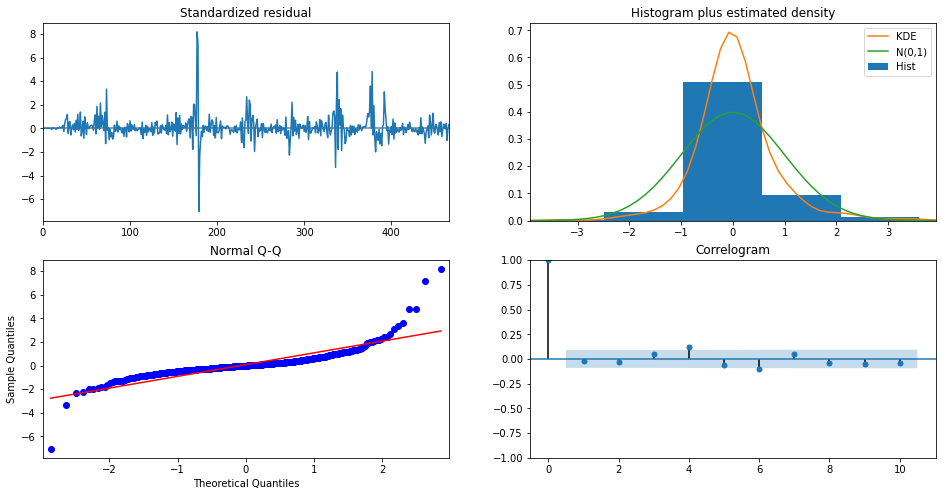

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

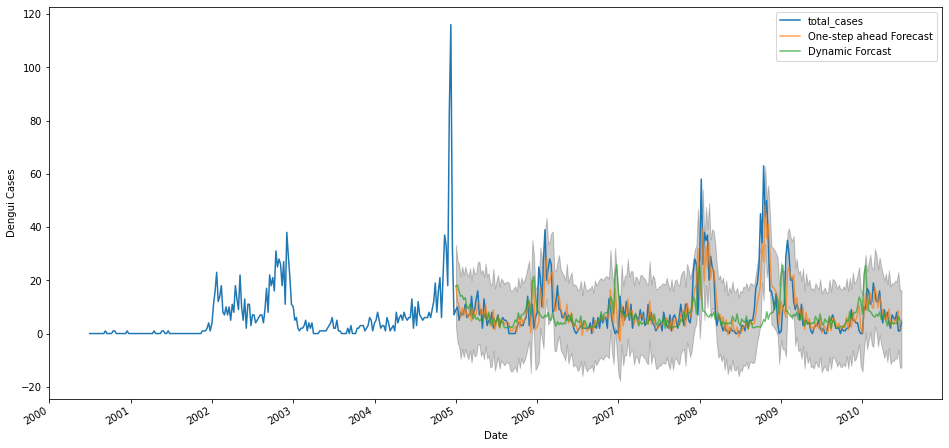

In [ ]:
pred = results.get_prediction(start= pd.to_datetime('2005-01-01'), dynamic=False)
pred_ci = pred.conf_int()

# Dynamic predictions
predict_dy = results.get_prediction(start=pd.to_datetime('2005-01-01'), dynamic=True)
predict_dy_ci = predict_dy.conf_int()

ax = cases_iq['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
predict_dy.predicted_mean.plot(ax=ax, label='Dynamic Forcast', alpha=.7, figsize=(16, 8))

ax.set_xlabel('Date')
ax.set_ylabel('Dengui Cases')
plt.legend()
plt.show()

In [ ]:
iq_sarima_forecast = results.forecast(steps=156)
iq_sarima_forecast

520    4.826121
521    2.347238
522    2.237770
523    2.967976
524    3.003111
         ...   
671    4.809810
672    5.994368
673    3.674183
674    3.875710
675    4.663760
Length: 156, dtype: float64

## Predicting sj cases

In [ ]:
cases_sj = cases_sj.set_index(pd.DatetimeIndex(cases_sj.index))
mod = SARIMAX(cases_sj,
        order=(1,0,0),
        seasonal_order=(2,1,1,53),
)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9638      0.003    295.695      0.000       0.957       0.970
ar.S.L53      -0.0319      0.045     -0.715      0.475      -0.119       0.056
ar.S.L106      0.0179      0.045      0.399      0.690      -0.070       0.106
ma.S.L53      -0.9503      0.111     -8.573      0.000      -1.168      -0.733
sigma2       189.0555     17.113     11.048      0.000     155.515     222.596


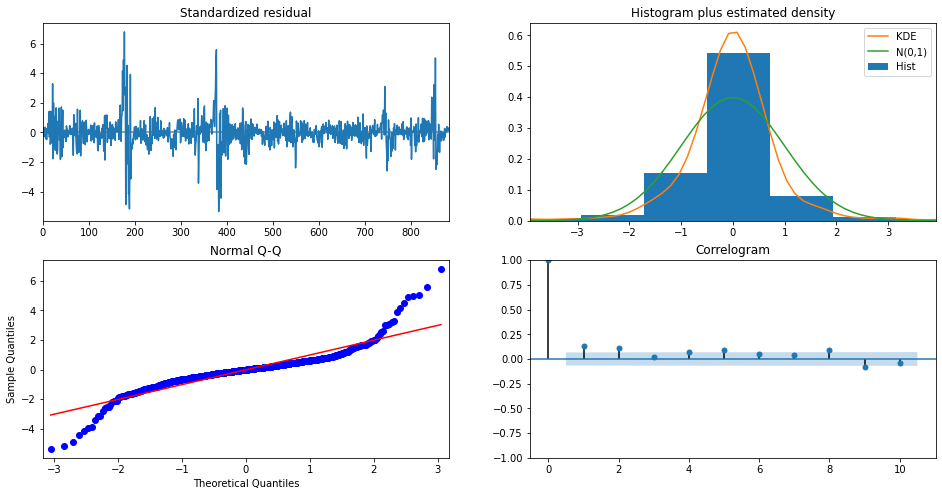

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

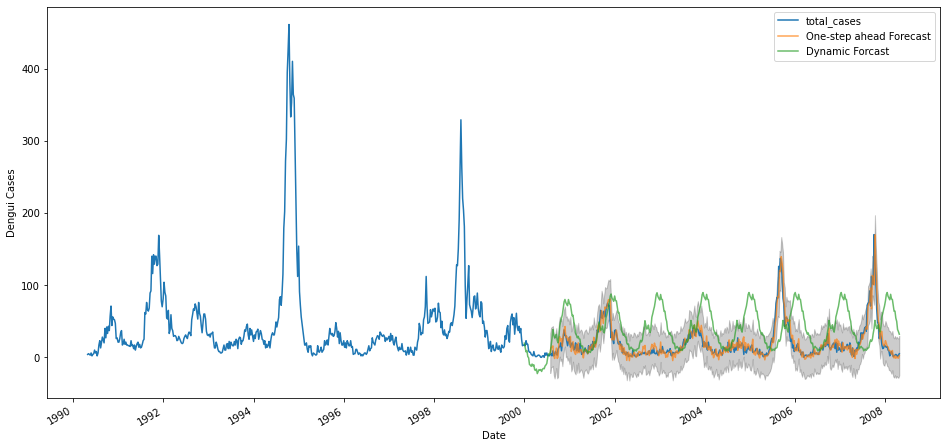

In [ ]:

pred = results.get_prediction(start=pd.to_datetime('2000-07-29'), dynamic=False)
pred_ci = pred.conf_int()

# Dynamic predictions
predict_dy = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=True)
predict_dy_ci = predict_dy.conf_int()

ax = cases_sj['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
predict_dy.predicted_mean.plot(ax=ax, label='Dynamic Forcast', alpha=.7, figsize=(16, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Dengui Cases')
plt.legend()
plt.show()

In [ ]:
sj_sarima_forecast = results.forecast(steps=260)
sj_sarima_forecast = sj_sarima_forecast.astype(int)
sj_sarima_forecast = sj_sarima_forecast.clip(lower=0)
sj_sarima_forecast
iq_sarima_forecast = iq_sarima_forecast.astype(int)
iq_sarima_forecast = iq_sarima_forecast.clip(lower=0)
iq_sarima_forecast

520    4
521    2
522    2
523    2
524    3
      ..
671    4
672    5
673    3
674    3
675    4
Length: 156, dtype: int64

In [ ]:
from google.colab import drive
drive.mount('drive')
def create_submission(forecast_sj, forecast_iq, sub_name):

    test_index = testingData[['city', 'year', 'weekofyear']]

    output = pd.concat([forecast_sj, forecast_iq])\
        .reset_index().drop(['index'], axis=1)

    output.columns = ['total_cases']

    pd.concat([test_index, output], axis=1)\
        .set_index(['city']).to_csv(sub_name + '.csv')

    !cp DengAI_SARIMA.csv "drive/My Drive/"

create_submission(sj_sarima_forecast, iq_sarima_forecast, 'DengAI_SARIMA')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


###SARIMA Score = 27.3942 Rank = 2409 /9002

## Implementing SARIMAX with Exogenous Regressors:

### Data Preprocessing:

Finding null values:

In [ ]:
#Finding the number of NUll or NaN values in the dataframe
trainingData.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
total_cases                                0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_ma

In [ ]:
testingData.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

Spliting traning data city vise:

In [ ]:
dengue_train_sj = trainingData[trainingData.city == 'sj'].copy()
dengue_train_sj.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,4,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,5,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,4,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,6,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
dengue_train_iq = trainingData[trainingData.city == 'iq'].copy()
dengue_train_iq.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,iq,2000,26,0,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,iq,2000,27,0,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,iq,2000,28,0,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,iq,2000,29,0,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,iq,2000,30,0,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0


In [ ]:
dengue_test_sj = testingData[testingData.city == 'sj'].copy()
dengue_test_sj.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [ ]:
dengue_test_iq = testingData[testingData.city == 'iq'].copy()
dengue_test_iq.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,293.7,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,292.2,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,292.5,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,289.3,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
264,iq,2010,30,2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,290.5,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0


In [ ]:
dengue_train_sj.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
total_cases                                0
week_start_date                            0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_ma

In [ ]:
dengue_train_iq.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
total_cases                               0
week_start_date                           0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c              

In [ ]:
dengue_test_sj.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                        2
station_diur_temp_rng_c                   2
station_max_temp_c                        2
station_min_temp_c              

In [ ]:
dengue_test_iq.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                   0
ndvi_nw                                   0
ndvi_se                                   0
ndvi_sw                                   0
precipitation_amt_mm                      0
reanalysis_air_temp_k                     0
reanalysis_avg_temp_k                     0
reanalysis_dew_point_temp_k               0
reanalysis_max_air_temp_k                 0
reanalysis_min_air_temp_k                 0
reanalysis_precip_amt_kg_per_m2           0
reanalysis_relative_humidity_percent      0
reanalysis_sat_precip_amt_mm              0
reanalysis_specific_humidity_g_per_kg     0
reanalysis_tdtr_k                         0
station_avg_temp_c                       10
station_diur_temp_rng_c                  10
station_max_temp_c                        1
station_min_temp_c              

Imputing Missing values with preceeding values:

In [ ]:
dengue_train_sj.fillna(method='ffill', inplace=True)

dengue_train_iq.fillna(method='ffill', inplace=True)

dengue_test_sj.fillna(method='ffill', inplace=True)

dengue_test_iq.fillna(method='ffill', inplace=True)

In [ ]:
dengue_train_sj.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
total_cases                              0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min

In [ ]:
dengue_train_iq.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
total_cases                              0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min

In [ ]:
dengue_test_sj.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

In [ ]:
dengue_test_iq.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

### Computing Correlation of features with total cases

In [ ]:
sj_correlations = dengue_train_sj.corr()
iq_correlations = dengue_train_iq.corr()

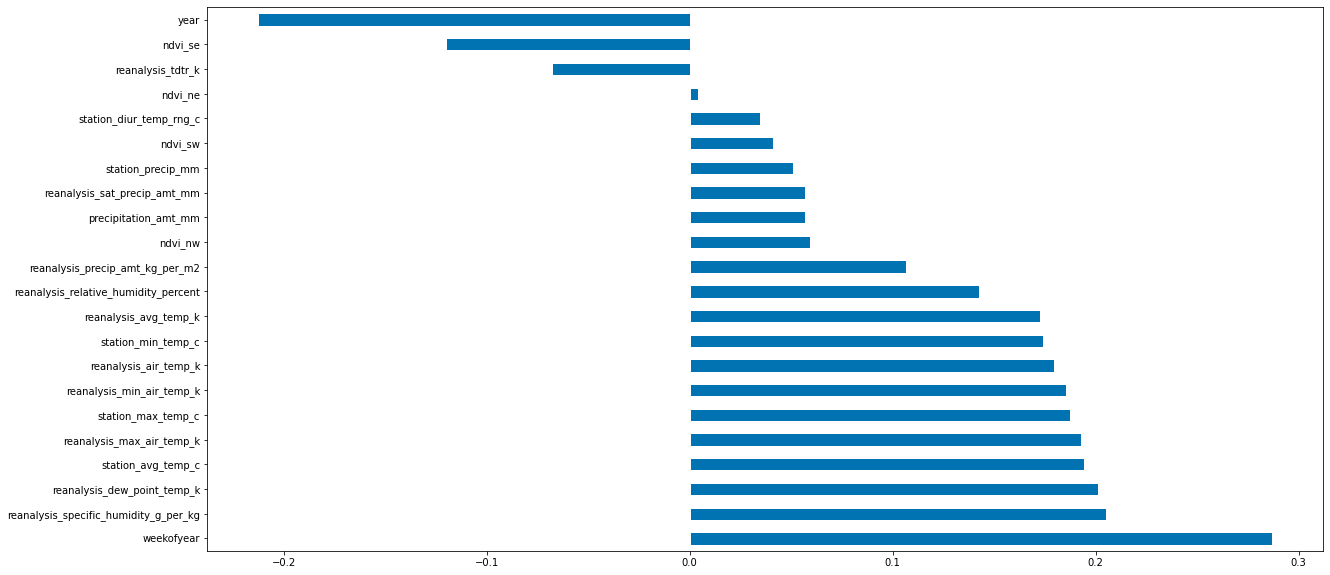

In [ ]:
# San Juan
fig, ax = plt.subplots(figsize=(20,10))
sns.set(style="ticks", palette="colorblind")
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh()
)


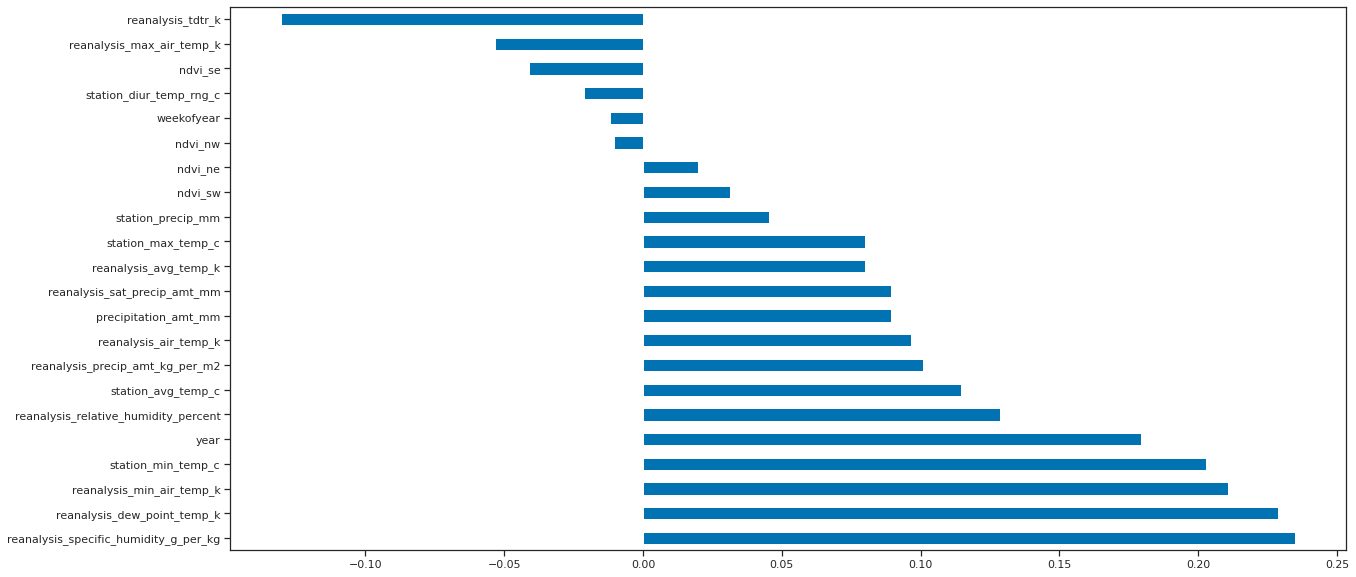

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.set(style="ticks", palette="colorblind")
# iq
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh()
)

###Strongly correlated features:
 1. reanalysis_specific_humidity_g_per_kg
 2. reanalysis_dew_point_temp_k
 3. station_avg_temp_c


This makes sense: we know mosquitos thrive in wet climates

Dropping other columns:

In [ ]:
dengue_train_sj = dengue_train_sj.loc[:,['total_cases', 'week_start_date', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k' , 'station_avg_temp_c']]
dengue_train_sj.set_index('week_start_date', inplace = True)
dengue_train_sj.head()

,total_cases,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c
week_start_date,,,,
1990-04-30,4,14.012857,292.414286,25.442857
1990-05-07,5,15.372857,293.951429,26.714286
1990-05-14,4,16.848571,295.434286,26.714286
1990-05-21,3,16.672857,295.310000,27.471429
1990-05-28,6,17.210000,295.821429,28.942857


In [ ]:
dengue_train_iq = dengue_train_iq.loc[:,['total_cases', 'week_start_date', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k' , 'station_avg_temp_c']]
dengue_train_iq.set_index('week_start_date', inplace = True)
dengue_train_iq.head()

,total_cases,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c
week_start_date,,,,
2000-07-01,0,16.651429,295.184286,26.400000
2000-07-08,0,16.862857,295.358571,26.900000
2000-07-15,0,17.120000,295.622857,26.800000
2000-07-22,0,14.431429,292.797143,25.766667
2000-07-29,0,15.444286,293.957143,26.600000


In [ ]:
dengue_test_sj = dengue_test_sj.loc[:,['week_start_date', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k' , 'station_avg_temp_c']]
dengue_test_sj.set_index('week_start_date', inplace = True)
dengue_test_sj.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c
week_start_date,,,
2008-04-29,15.918571,294.527143,26.528571
2008-05-06,15.791429,294.395714,26.071429
2008-05-13,16.674286,295.308571,27.928571
2008-05-20,15.775714,294.402857,28.057143
2008-05-27,16.137143,294.760000,27.614286


In [ ]:
dengue_test_iq = dengue_test_iq.loc[:,['week_start_date', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k' , 'station_avg_temp_c']]
dengue_test_iq.set_index('week_start_date', inplace = True)
dengue_test_iq.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c
week_start_date,,,
2010-07-02,17.654286,296.118571,27.440
2010-07-09,16.320000,294.831429,27.025
2010-07-16,18.030000,296.417143,26.950
2010-07-23,15.394286,293.638571,26.900
2010-07-30,15.468571,293.892857,27.050


Splitting feature and target variables:

In [ ]:
endog_iq = pd.DataFrame(dengue_train_iq.loc[:,'total_cases'])
exog_iq  = dengue_train_iq.loc[:,[  'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k' , 'station_avg_temp_c']]


In [ ]:
endog_iq.head()

,total_cases
week_start_date,
2000-07-01,0
2000-07-08,0
2000-07-15,0
2000-07-22,0
2000-07-29,0


In [ ]:
exog_iq.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c
week_start_date,,,
2000-07-01,16.651429,295.184286,26.400000
2000-07-08,16.862857,295.358571,26.900000
2000-07-15,17.120000,295.622857,26.800000
2000-07-22,14.431429,292.797143,25.766667
2000-07-29,15.444286,293.957143,26.600000


In [ ]:
endog_sj = pd.DataFrame(dengue_train_sj.loc[:,'total_cases'])
exog_sj  = dengue_train_sj.loc[:,[  'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k' , 'station_avg_temp_c']]


In [ ]:
endog_sj.head()

,total_cases
week_start_date,
1990-04-30,4
1990-05-07,5
1990-05-14,4
1990-05-21,3
1990-05-28,6


In [ ]:
exog_sj.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c
week_start_date,,,
1990-04-30,14.012857,292.414286,25.442857
1990-05-07,15.372857,293.951429,26.714286
1990-05-14,16.848571,295.434286,26.714286
1990-05-21,16.672857,295.310000,27.471429
1990-05-28,17.210000,295.821429,28.942857


### Normalizing Features:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
x = exog_sj.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
exog_sj = pd.DataFrame(x_scaled, columns=exog_sj.columns, index=exog_sj.index)
exog_sj.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c
week_start_date,,,
1990-04-30,0.297392,0.339933,0.359684
1990-05-07,0.473460,0.528474,0.535573
1990-05-14,0.664509,0.710356,0.535573
1990-05-21,0.641761,0.695111,0.640316
1990-05-28,0.711300,0.757841,0.843874


In [ ]:
x = exog_iq.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
exog_iq = pd.DataFrame(x_scaled, columns=exog_iq.columns, index=exog_iq.index)
exog_iq.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c
week_start_date,,,
2000-07-01,0.543713,0.609431,0.531915
2000-07-08,0.569033,0.630275,0.585106
2000-07-15,0.599829,0.661883,0.574468
2000-07-22,0.277844,0.323936,0.464539
2000-07-29,0.399145,0.462669,0.553191


In [ ]:
x = dengue_test_iq.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dengue_test_iq = pd.DataFrame(x_scaled, columns=dengue_test_iq.columns, index=dengue_test_iq.index)
dengue_test_iq.head()


,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c
week_start_date,,,
2010-07-02,0.668291,0.721535,0.605590
2010-07-09,0.440653,0.498515,0.508929
2010-07-16,0.732391,0.773267,0.491460
2010-07-23,0.282720,0.291832,0.479814
2010-07-30,0.295394,0.335891,0.514752


In [ ]:
x = dengue_test_sj.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dengue_test_sj = pd.DataFrame(x_scaled, columns=dengue_test_sj.columns, index=dengue_test_sj.index)
dengue_test_sj.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c
week_start_date,,,
2008-04-29,0.497060,0.531640,0.387850
2008-05-06,0.478370,0.512800,0.313084
2008-05-13,0.608148,0.643662,0.616822
2008-05-20,0.476060,0.513823,0.637850
2008-05-27,0.529189,0.565022,0.565421


###Resampling Data from weekly to monthly:

In [ ]:
resample_exog_iq = exog_iq
resample_exog_iq.index = pd.to_datetime(resample_exog_iq.index)
resample_exog_iq = exog_iq.resample('M').mean()

resample_endog_iq = endog_iq
resample_endog_iq.index = pd.to_datetime(resample_endog_iq.index)
resample_endog_iq = endog_iq.resample('M').mean()

resample_exog_sj = exog_sj
resample_exog_sj.index = pd.to_datetime(resample_exog_sj.index)
resample_exog_sj = exog_sj.resample('M').mean()

resample_endog_sj = endog_sj
resample_endog_sj.index = pd.to_datetime(resample_endog_sj.index)
resample_endog_sj = endog_sj.resample('M').mean()


Text(0.5, 1.0, 'sj features resampled')

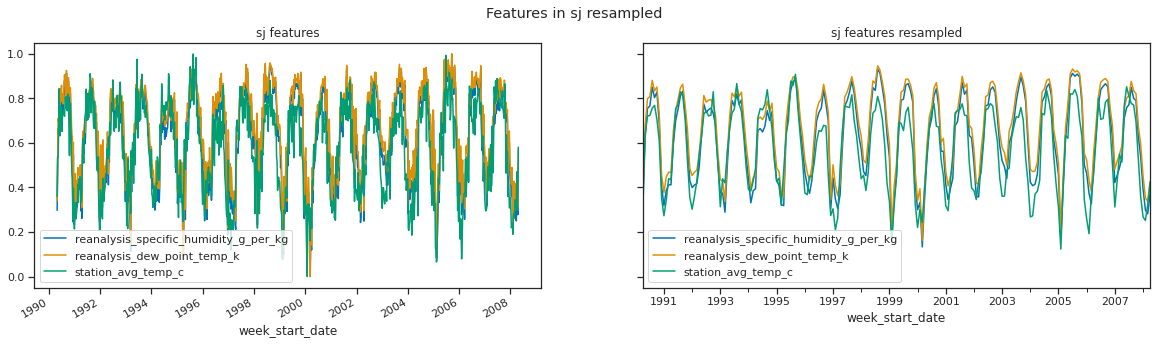

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Features in sj resampled')
fig.set_size_inches(20,5)
ax = exog_sj.plot(ax=ax1);
ax1.set_title('sj features')
ax = resample_exog_sj.plot(ax=ax2);
ax2.set_title('sj features resampled')

##Grid Search for iq with climate features

In [ ]:
stepwise_model = auto_arima(resample_endog_iq, exogenous = resample_exog_iq,
                           trace=True,
                            m=12,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=False,
                            random=True,
                            n_fits =300,
                           out_of_sample_size =6,
                            maxiter =300,
                            scoring = 'mae',
                            D=1
                           )
print(stepwise_model.bic())

Fit ARIMA(2,0,0)x(0,1,1,12) [intercept=True]; AIC=783.558, BIC=805.015, Time=2.102 seconds
Fit ARIMA(1,0,2)x(0,1,2,12) [intercept=True]; AIC=786.132, BIC=812.953, Time=13.031 seconds
Fit ARIMA(0,0,0)x(2,1,1,12) [intercept=True]; AIC=814.293, BIC=835.750, Time=6.411 seconds
Fit ARIMA(0,0,4)x(0,1,0,12) [intercept=True]; AIC=844.701, BIC=868.841, Time=1.778 seconds
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=781.913, BIC=803.370, Time=1.929 seconds
Fit ARIMA(3,0,1)x(0,1,1,12) [intercept=True]; AIC=785.511, BIC=812.333, Time=3.447 seconds
Fit ARIMA(0,0,2)x(2,1,1,12) [intercept=True]; AIC=782.732, BIC=809.553, Time=6.168 seconds
Fit ARIMA(0,0,0)x(1,1,2,12) [intercept=True]; AIC=813.456, BIC=834.913, Time=7.426 seconds
Fit ARIMA(1,0,2)x(1,1,1,12) [intercept=True]; AIC=785.803, BIC=812.624, Time=7.275 seconds
Fit ARIMA(0,0,1)x(1,1,0,12) [intercept=True]; AIC=795.465, BIC=814.239, Time=2.575 seconds
Fit ARIMA(0,0,0)x(0,1,1,12) [intercept=True]; AIC=815.135, BIC=831.228, Time=1.808 second

Fit ARIMA(0,0,1)x(1,1,2,12) [intercept=True]; AIC=780.396, BIC=804.535, Time=4.458 seconds

In [ ]:
mod = SARIMAX(endog_iq, exog_iq,
        order=(0,0,1),
        seasonal_order=(1,1,2,53)
)
results = mod.fit()
print(results.summary().tables[1])

                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
reanalysis_specific_humidity_g_per_kg     6.2660     46.431      0.135      0.893     -84.737      97.269
reanalysis_dew_point_temp_k              -4.4797     47.276     -0.095      0.925     -97.138      88.179
station_avg_temp_c                       -1.7306      4.233     -0.409      0.683     -10.027       6.566
ma.L1                                     0.6086      0.019     32.800      0.000       0.572       0.645
ar.S.L53                                 -0.9998     19.748     -0.051      0.960     -39.705      37.706
ma.S.L53                                 -0.0004     19.548   -2.2e-05      1.000     -38.314      38.313
ma.S.L106                                -0.9996     55.056     -0.018      0.986    -108.908     106.909
sigma2                                   66.33

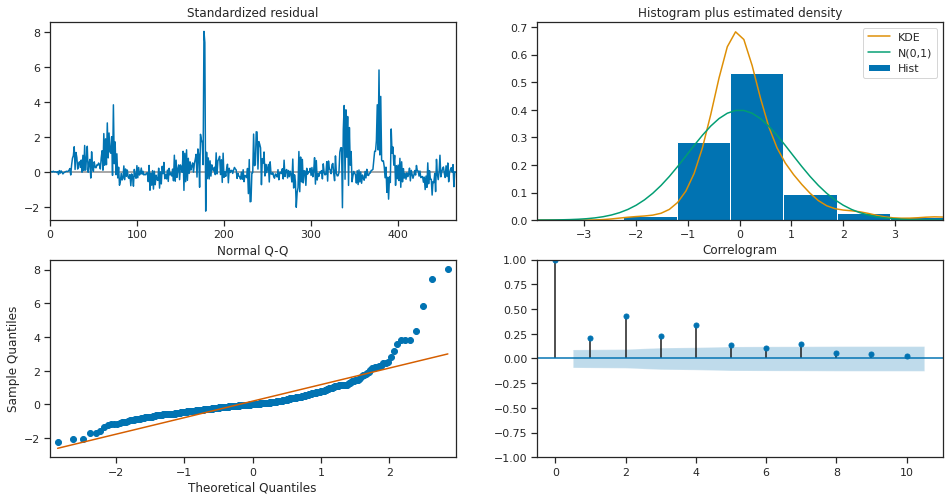

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

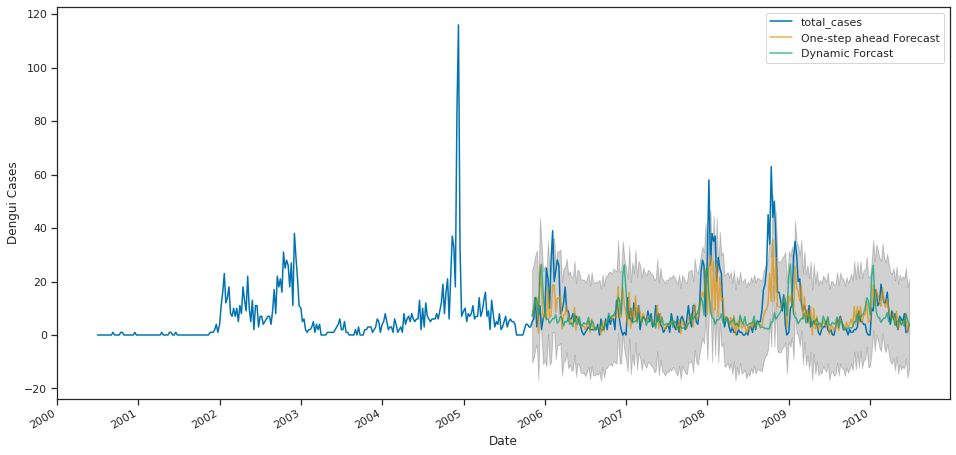

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2005-11-05'), dynamic=False)
pred_ci = pred.conf_int()

# Dynamic predictions
predict_dy = results.get_prediction(start=pd.to_datetime('2005-11-05'), dynamic=True)
predict_dy_ci = predict_dy.conf_int()

ax = endog_iq['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
predict_dy.predicted_mean.plot(ax=ax, label='Dynamic Forcast', alpha=.7, figsize=(16, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Dengui Cases')
plt.legend()
plt.show()

In [ ]:
iq_sarimax_forecast = results.forecast(steps=156, exog = dengue_test_iq)

In [ ]:
mod = SARIMAX(endog_iq, exog_iq,
        order=(2,0,1),
        seasonal_order=(1,1,1,53)
)
results = mod.fit()
print(results.summary().tables[1])

                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
reanalysis_specific_humidity_g_per_kg   -45.7389     48.171     -0.950      0.342    -140.153      48.675
reanalysis_dew_point_temp_k              42.5474     48.811      0.872      0.383     -53.121     138.215
station_avg_temp_c                       -1.9037      3.959     -0.481      0.631      -9.663       5.856
ar.L1                                    -0.2429      0.579     -0.420      0.675      -1.377       0.892
ar.L2                                     0.7244      0.421      1.719      0.086      -0.101       1.550
ma.L1                                     0.9801      0.587      1.670      0.095      -0.170       2.130
ar.S.L53                                 -0.0335      0.053     -0.636      0.525      -0.137       0.070
ma.S.L53                                 -0.99

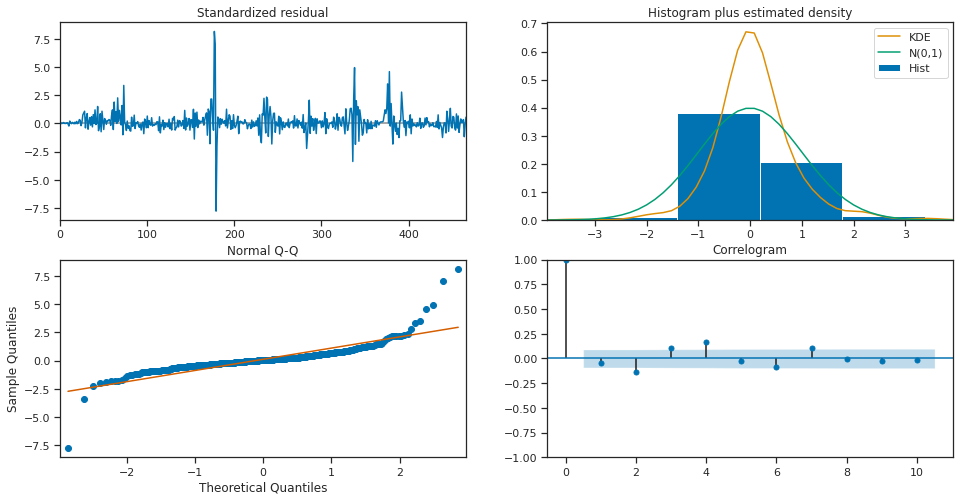

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

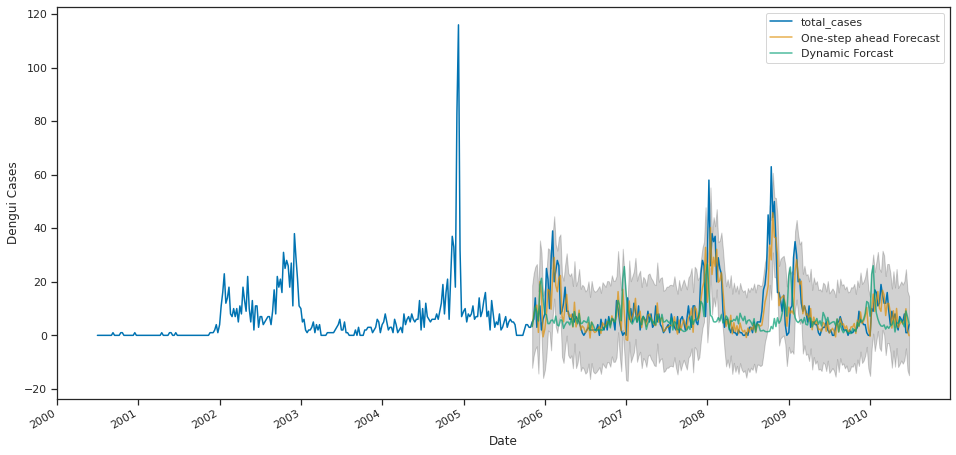

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2005-11-05'), dynamic=False)
pred_ci = pred.conf_int()

# Dynamic predictions
predict_dy = results.get_prediction(start=pd.to_datetime('2005-11-05'), dynamic=True)
predict_dy_ci = predict_dy.conf_int()

ax = endog_iq['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
predict_dy.predicted_mean.plot(ax=ax, label='Dynamic Forcast', alpha=.7, figsize=(16, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Dengui Cases')
plt.legend()
plt.show()

## Grid Search for sj with clmate variables

In [ ]:
stepwise_model = auto_arima(resample_endog_sj, exogenous = resample_exog_sj,
                           trace=True,
                            m=24,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=False,
                            random=True,
                            n_fits =300,
                           out_of_sample_size =6,
                            maxiter =300,
                            scoring = 'mae',
                            D=1
                           )
print(stepwise_model.aic())

Fit ARIMA(0,0,0)x(2,1,0,24) [intercept=True]; AIC=2103.505, BIC=2126.344, Time=40.015 seconds
Fit ARIMA(0,0,3)x(2,1,0,24) [intercept=True]; AIC=1851.167, BIC=1883.794, Time=153.606 seconds
Fit ARIMA(1,0,1)x(1,1,1,24) [intercept=True]; AIC=1830.856, BIC=1860.221, Time=49.418 seconds
Fit ARIMA(1,0,2)x(0,1,0,24) [intercept=True]; AIC=1908.549, BIC=1934.651, Time=10.931 seconds
Fit ARIMA(0,0,0)x(1,1,1,24) [intercept=True]; AIC=2093.551, BIC=2116.389, Time=15.916 seconds
Fit ARIMA(4,0,0)x(0,1,1,24) [intercept=True]; AIC=1823.706, BIC=1856.333, Time=54.218 seconds
Fit ARIMA(4,0,0)x(0,1,0,24) [intercept=True]; AIC=1909.903, BIC=1939.267, Time=13.162 seconds
Fit ARIMA(0,0,0)x(1,1,2,24) [intercept=True]; AIC=2095.005, BIC=2121.107, Time=52.939 seconds
Fit ARIMA(0,0,4)x(1,1,0,24) [intercept=True]; AIC=1868.440, BIC=1901.067, Time=87.069 seconds
Fit ARIMA(0,0,3)x(0,1,2,24) [intercept=True]; AIC=1826.709, BIC=1859.336, Time=141.958 seconds
Fit ARIMA(0,0,5)x(0,1,0,24) [intercept=True]; AIC=1918.009

Best Models:

Fit ARIMA(2,0,1)x(0,1,1,12) AIC=1906.211, BIC=1936.118

Fit ARIMA(3,1,1)x(0,1,1,12) AIC=1906.424

Fit ARIMA(3,0,0)x(0,1,1,24) [intercept=True]; AIC=1821.931, BIC=1851.295

In [ ]:
mod = SARIMAX(endog_sj,exog_sj,
        order=(1,0,0),
        seasonal_order=(2,1,1,52),
)
results = mod.fit()
print(results.summary().tables[1])

                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
reanalysis_specific_humidity_g_per_kg   -81.8747     55.553     -1.474      0.141    -190.756      27.006
reanalysis_dew_point_temp_k              81.1083     56.778      1.429      0.153     -30.174     192.391
station_avg_temp_c                        8.1726      6.802      1.201      0.230      -5.160      21.505
ar.L1                                     0.9628      0.004    272.858      0.000       0.956       0.970
ar.S.L52                                 -0.0314      0.036     -0.882      0.378      -0.101       0.038
ar.S.L104                                 0.0192      0.035      0.546      0.585      -0.050       0.088
ma.S.L52                                 -0.9258      0.046    -20.125      0.000      -1.016      -0.836
sigma2                                  189.31

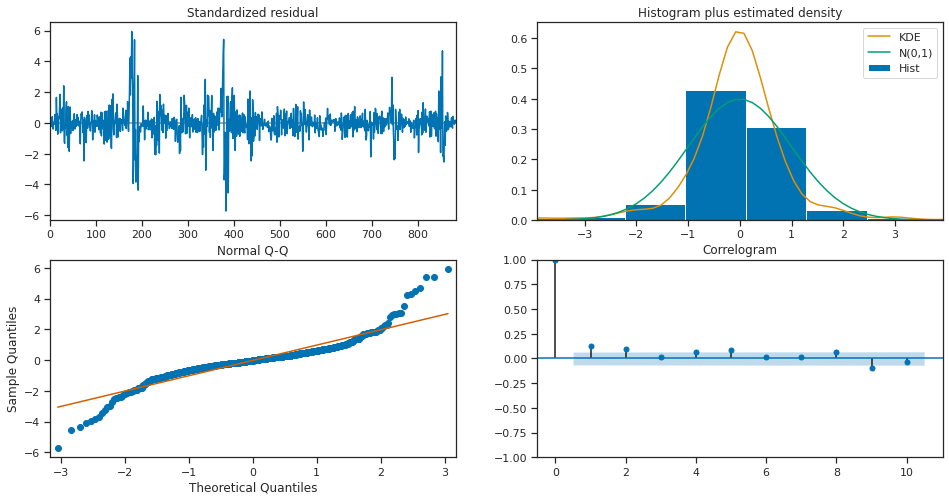

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

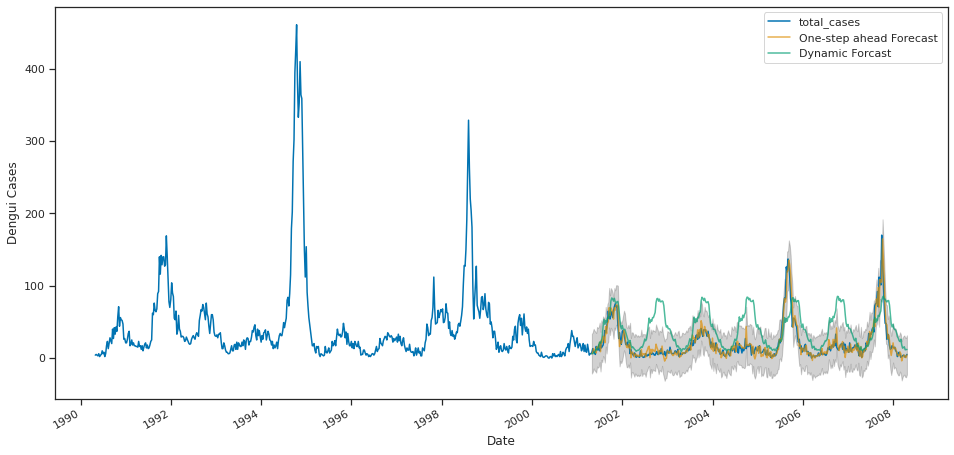

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2001-04-30'), dynamic=False)
pred_ci = pred.conf_int()

# Dynamic predictions
predict_dy = results.get_prediction(start=pd.to_datetime('2001-04-30'), dynamic=True)
predict_dy_ci = predict_dy.conf_int()

ax = endog_sj['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
predict_dy.predicted_mean.plot(ax=ax, label='Dynamic Forcast', alpha=.7, figsize=(16, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Dengui Cases')
plt.legend()
plt.show()

In [ ]:
sj_sarimax_forecast = results.forecast(steps=260, exog = dengue_test_sj)
mean_absolute_error(endog_sj[-len(predict_dy.predicted_mean):], predict_dy.predicted_mean)

24.93448932162892

In [ ]:
mod = SARIMAX(endog_sj,exog_sj,
        order=(3,1,1),
        seasonal_order=(0,1,1,53),
)
results = mod.fit()
print(results.summary().tables[1])

                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
reanalysis_specific_humidity_g_per_kg    91.6850     59.129      1.551      0.121     -24.207     207.577
reanalysis_dew_point_temp_k             -88.9846     62.252     -1.429      0.153    -210.996      33.027
station_avg_temp_c                        8.5900      6.030      1.425      0.154      -3.228      20.408
ar.L1                                    -0.8774      0.024    -36.103      0.000      -0.925      -0.830
ar.L2                                     0.1881      0.017     10.883      0.000       0.154       0.222
ar.L3                                     0.0730      0.017      4.185      0.000       0.039       0.107
ma.L1                                     0.9860      0.021     47.538      0.000       0.945       1.027
ma.S.L53                                 -0.99

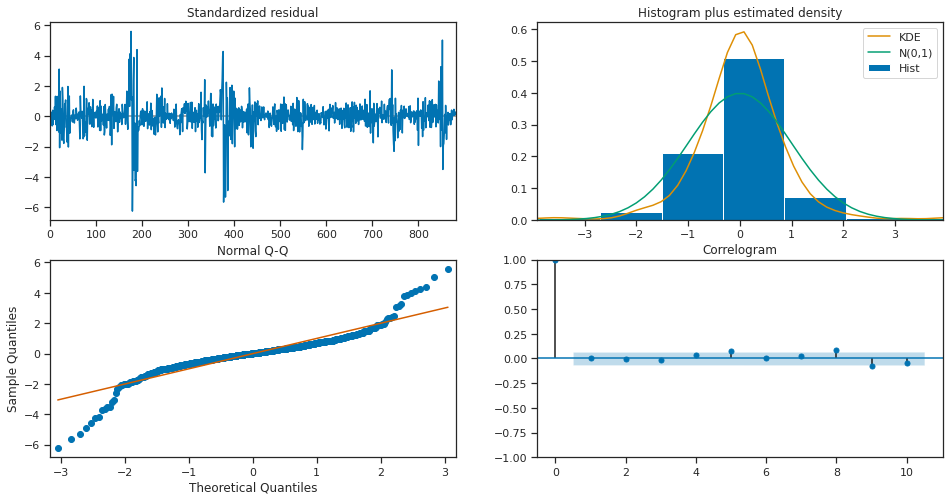

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

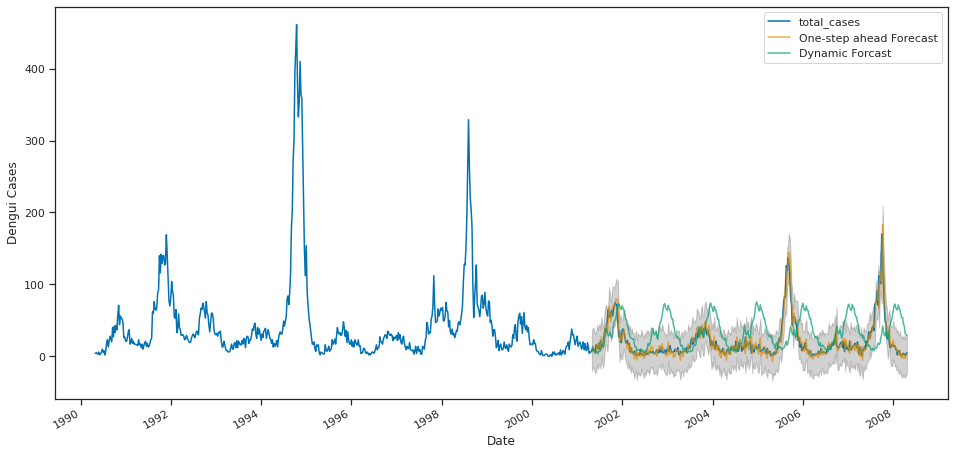

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2001-04-30'), dynamic=False)
pred_ci = pred.conf_int()

# Dynamic predictions
predict_dy = results.get_prediction(start=pd.to_datetime('2001-04-30'), dynamic=True)
predict_dy_ci = predict_dy.conf_int()

ax = endog_sj['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
predict_dy.predicted_mean.plot(ax=ax, label='Dynamic Forcast', alpha=.7, figsize=(16, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Dengui Cases')
plt.legend()
plt.show()


In [ ]:
mean_absolute_error(endog_sj[-len(predict_dy.predicted_mean):], predict_dy.predicted_mean)

27.517333580171826

In [ ]:
sj_sarimax_forecast = sj_sarimax_forecast.astype(int)
sj_sarimax_forecast = sj_sarimax_forecast.clip(lower=0)
sj_sarimax_forecast
iq_sarimax_forecast = iq_sarimax_forecast.astype(int)
iq_sarimax_forecast = iq_sarimax_forecast.clip(lower=0)
iq_sarimax_forecast

520    4
521    2
522    3
523    3
524    3
      ..
671    4
672    5
673    3
674    3
675    4
Length: 156, dtype: int64

In [ ]:
sj_sarimax_forecast

936      3
937      2
938      5
939      5
940      7
        ..
1191    11
1192     8
1193     9
1194     9
1195     5
Length: 260, dtype: int64

In [ ]:
from google.colab import drive
drive.mount('drive')
def create_submission(forecast_sj, forecast_iq, sub_name):

    test_index = testingData[['city', 'year', 'weekofyear']]

    output = pd.concat([forecast_sj, forecast_iq])\
        .reset_index().drop(['index'], axis=1)

    output.columns = ['total_cases']

    pd.concat([test_index, output], axis=1)\
        .set_index(['city']).to_csv(sub_name + '.csv')

    !cp DengAI_SARIMAX.csv "drive/My Drive/"

create_submission(sj_sarimax_forecast, iq_sarimax_forecast, 'DengAI_SARIMAX')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


#Score 25.5288 -  Rank 1094 / 9012
